In [189]:
import pandas as pd
import os.path as op
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
from tools import smooth_csd
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import MDS

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap="RdBu_r"
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()


def binarise(array, low=-1, high=1):
    array[array<0] = low
    array[array==0] = 0
    array[array>0] = high
    return array

In [4]:
info_path = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(info_path, "r") as fp:
    info = json.load(fp)

In [5]:
info.keys()

dict_keys(['dataset_dir', 'which_dataset', 'anatomy_dir', 'annot_paths', 'fsavg_sphere_paths', 'atlas', 'subject_info', 'freesurfer_singularity', 'big_brain_path', 'fsnat_sphere_paths', 'subject_path', 'pial', 'white', 'pial_ds', 'white_ds', 'pial_ds_nodeep', 'white_ds_nodeep', 'pial_ds_nodeep_inflated', 'multilayer', 'n_surf', 'atlas_labels_path', 'atlas_colors_path', 'cortical_thickness_path', 'big_brain_layers_path', 'sensor_epochs_paths', 'MU_paths'])

In [6]:
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])

csd_files = files.get_files(
    op.join(info["subject_path"], "inverted"),
    "time_CSD", "npy"
)[2]

In [7]:
times = {
    "visual": np.linspace(-0.2, 0.8, num=601),
    "motor": np.linspace(-0.5, 0.5, num=601)
}

In [8]:
ROI_labels = ["L_V1_ROI", "R_V1_ROI"]
total_ix = np.arange(atlas_labels.shape[0])
ROI_vertices = {i: total_ix[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
cds = np.load(csd_files[1])

In [186]:
SMOOTH_CSD = {}
for l in ROI_labels:
    SMOOTH_CSD[l] = []
    for rv in ROI_vertices[l]:
        SMOOTH_CSD[l].append(smooth_csd(cds[rv, :, :], info["n_surf"]))

In [454]:
SMOOTH_CSD["L_V1_ROI"][0].shape

(500, 601)

In [ ]:
f, ax = plt.subplots(1,1, figsize=(7,6), facecolor="white")
plot_csd(
    SMOOTH_CSD["L_V1_ROI"][0], ROI_vertices["L_V1_ROI"],
    info["big_brain_layers_path"], times["visual"], ax
)

f, ax = plt.subplots(1,1, figsize=(7,6), facecolor="white")
plot_csd(
    binarise(copy(SMOOTH_CSD["L_V1_ROI"][0]), low=0, high=1), ROI_vertices["L_V1_ROI"],
    info["big_brain_layers_path"], times["visual"], ax
)

f, ax = plt.subplots(1,1, figsize=(7,6), facecolor="white")
plot_csd(
    np.nanmean(SMOOTH_CSD["L_V1_ROI"], axis=0), ROI_vertices["L_V1_ROI"],
    info["big_brain_layers_path"], times["visual"], ax
)

In [9]:
true_CSD = {}
for l in ROI_labels:
    true_CSD[l] = []
    for rv in ROI_vertices[l]:
        true_CSD[l].append(cds[rv, :, :])

In [10]:
dataset = np.array([i.flatten() for i in true_CSD["L_V1_ROI"]])
dataset = dataset.astype(float)
dataset[np.isinf(dataset)] = np.max(dataset[~np.isinf(dataset)])
scaler = RobustScaler()
scaler.fit(dataset)
scaled_dataset = scaler.transform(dataset)

In [11]:
pca = PCA(n_components=100)
pca.fit(scaled_dataset)
dataset_pca = pca.transform(scaled_dataset)

7


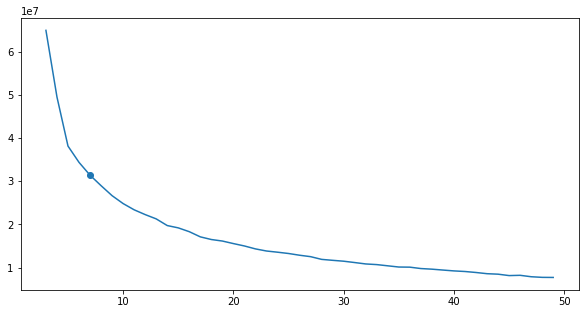

In [12]:
sse = []
list_k = np.arange(3,50)

for k in list_k:
    km = KMeans(n_clusters=k, random_state=21, n_jobs=-1)
    km.fit(dataset_pca)
    sse.append(km.inertia_)

f, ax = plt.subplots(1, figsize=[10, 5])
ax.plot(list_k, sse)
fwhm_ix = np.where(sse < np.max(sse)/2)[0][0]
ax.scatter([list_k[fwhm_ix]], [sse[fwhm_ix]])
final_k = list_k[fwhm_ix]
print(list_k[fwhm_ix])

In [13]:
km = KMeans(n_clusters=20, random_state=21, n_jobs=-1)
km.fit(dataset_pca)
cluster_dist = km.transform(dataset_pca)
cluster_labels = km.labels_

In [14]:
cluster_maps = {i: cluster_labels == i for i in np.unique(cluster_labels)}

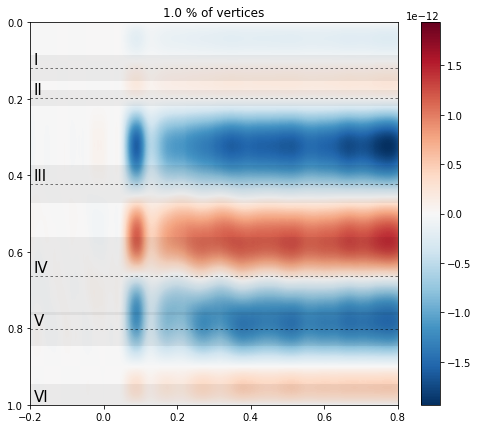

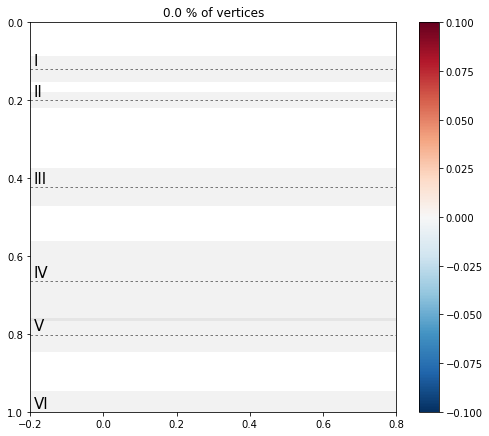

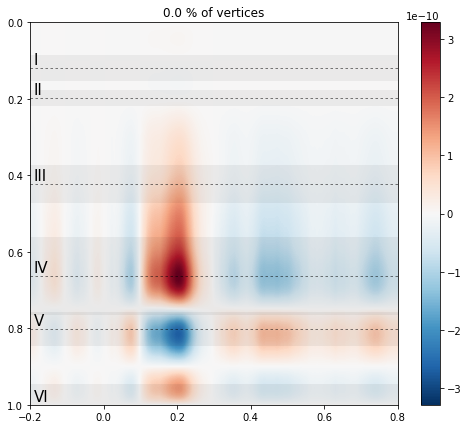

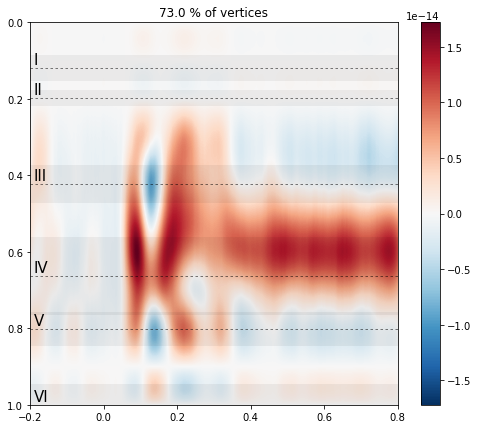

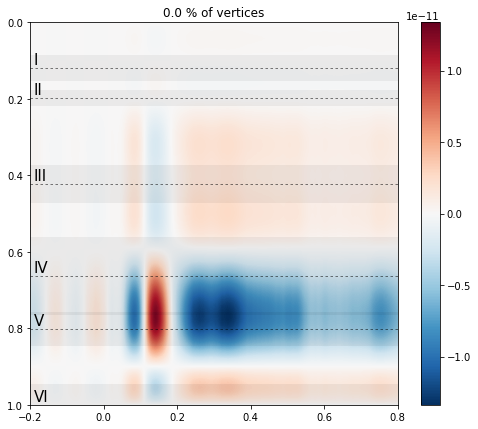

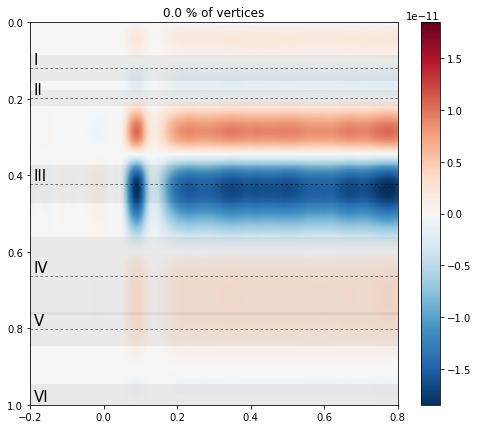

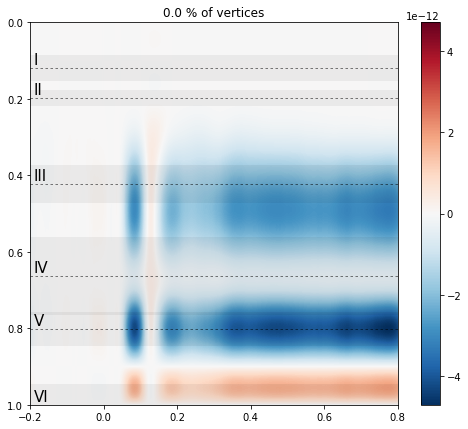

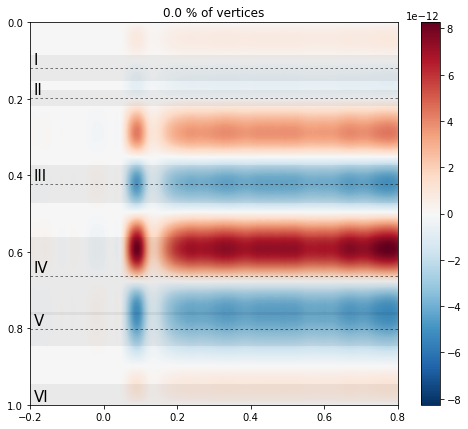

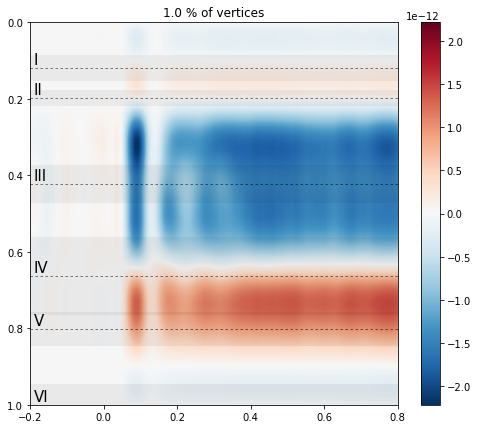

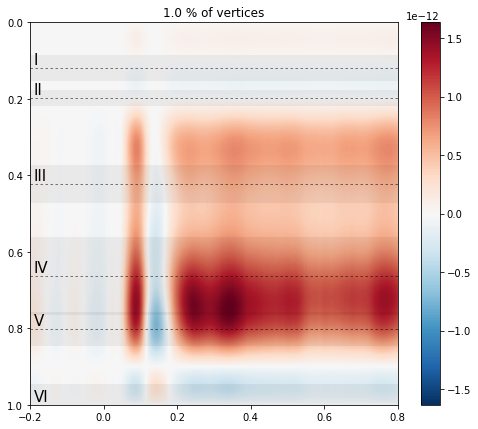

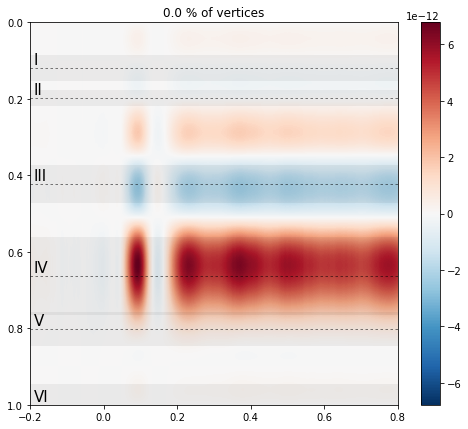

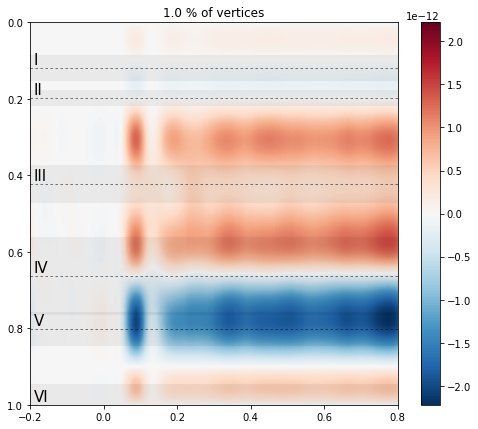

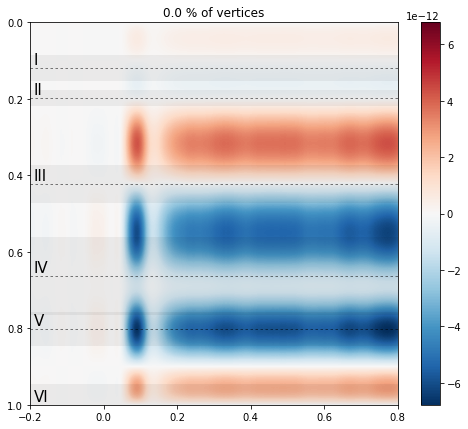

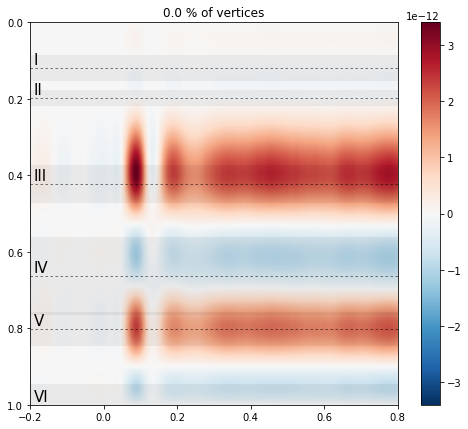

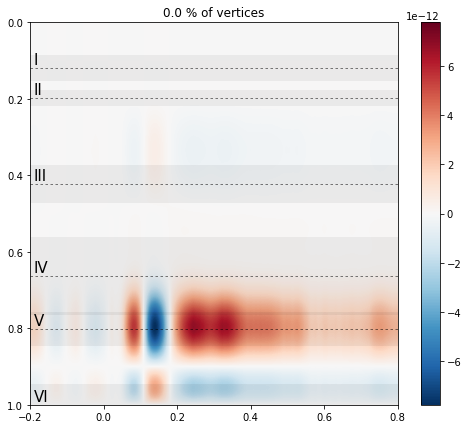

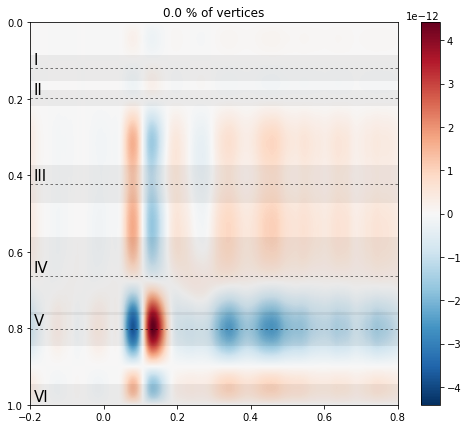

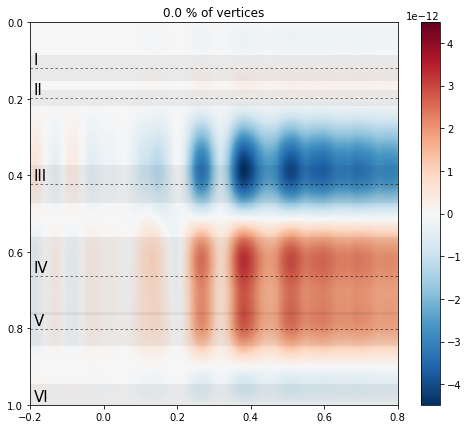

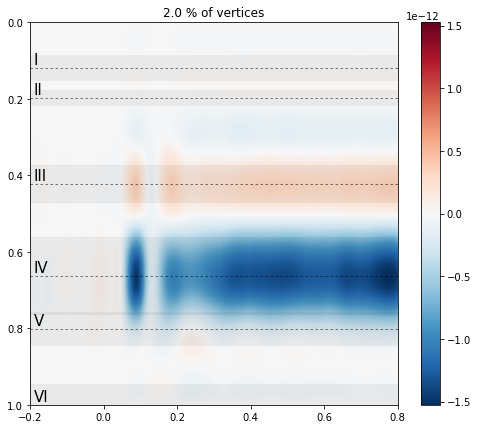

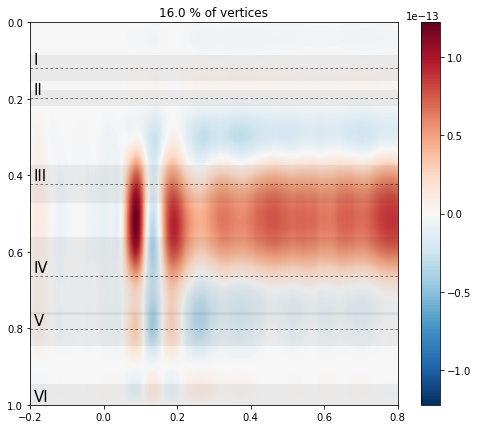

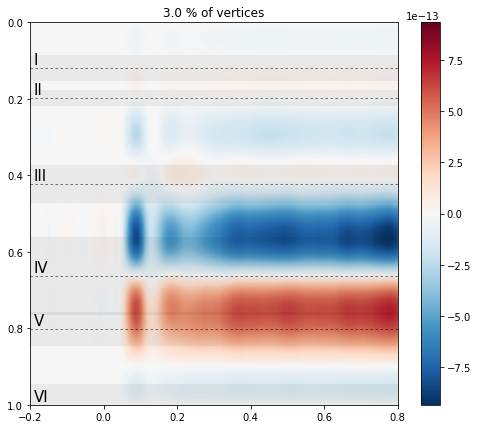

In [187]:
smooth = np.array(SMOOTH_CSD["L_V1_ROI"])

for i in cluster_maps.keys():
    f, ax = plt.subplots(1,1, figsize=(7,6), facecolor="white")
    csd_tar = np.nanmean(smooth[cluster_maps[i], :], axis=0)
    baseline = np.mean(csd_tar[:, np.where(times["visual"] < -0.01)], axis=2)
        
    plot_csd(
        csd_tar - baseline, ROI_vertices["L_V1_ROI"],
        info["big_brain_layers_path"], times["visual"], ax
    )
    ax.set_title("{} % of vertices".format(np.round(np.mean(cluster_maps[i])*100), 2))

In [83]:
cl_map = np.zeros(cluster_maps[0].shape[0])
for i in cluster_maps.keys():
    if np.mean(cluster_maps[i])*100 > 2:
        cl_map[cluster_maps[i]] = i
    else:
        cl_map[cluster_maps[i]] = 99

In [196]:
np.unique(cl_map)

array([ 3., 18., 19., 99.])

In [133]:
cs = plt.cm.brg(np.linspace(0, 1, num=np.unique(cl_map).shape[0]-1))
cs = [np.array(i[:3]) for i in cs]
sc_c = np.array([1., 1., 1.])
gray = np.array([0.5, 0.5, 0.5])
cs.append(sc_c)

In [134]:
cs

[array([0., 0., 1.]),
 array([0.99607843, 0.00392157, 0.        ]),
 array([0., 1., 0.]),
 array([1., 1., 1.])]

In [163]:
info["pial_ds_nodeep"]

'/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/pial.ds.link_vector.nodeep.gii'

In [171]:
brain = nb.load(info["pial_ds_nodeep_inflated"]);
vertices, faces = brain.agg_data()

In [172]:
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    c_ix = np.where(np.unique(cl_map)==cl_map[ix])[0][0]
    colours[v, :] = cs[c_ix]

In [185]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
mask = [i.decode("utf=8")[0] == "R" for i in atlas_labels]
mesh.remove_vertices_by_mask(mask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [183]:
atlas_labels[-1].decode("utf=8")[0] == "L"

False

In [191]:
low_dim = MDS(n_components=2)
low_dim_transformed = low_dim.fit_transform(cluster_dist)

In [193]:
low_dim_transformed

(725, 2)

3.0
18.0
19.0
99.0


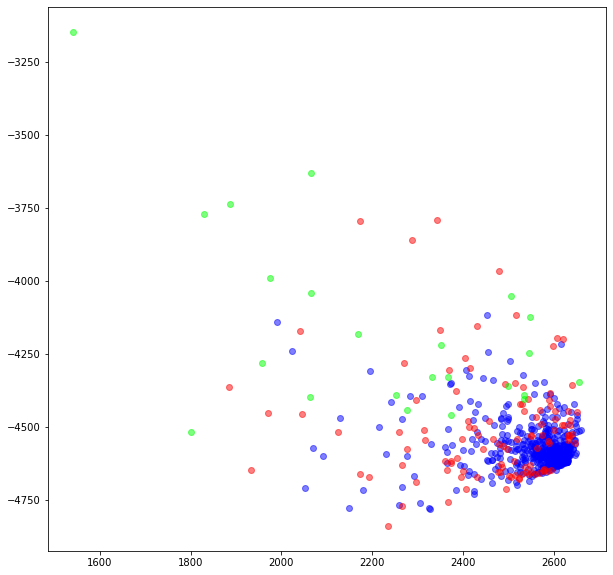

In [241]:
clab = plt.cm.brg(np.linspace(0, 1, num=np.unique(cl_map).shape[0]-1))
f, ax = plt.subplots(1, figsize=(10,10))
for ix, lab in enumerate(np.unique(cl_map)):
    print(lab)
    if lab != 99.:
        x = low_dim_transformed[cl_map == lab][:,0]
        y = low_dim_transformed[cl_map == lab][:,1]
        c = clab[ix]
        ax.scatter(x, y, color=c, alpha=0.5)

In [211]:
np.insert(clab, np.array([0.5, 0.5, 0.5, 1]), -1, axis=0)

IndexError: arrays used as indices must be of integer (or boolean) type

In [221]:
clab = plt.cm.brg(np.linspace(0, 1, num=np.unique(cl_map).shape[0]-1))
print(clab)


[[0.         0.         1.         1.        ]
 [0.99607843 0.00392157 0.         1.        ]
 [0.         1.         0.         1.        ]]


array([[0.        , 0.        , 1.        , 1.        ],
       [0.99607843, 0.00392157, 0.        , 1.        ],
       [0.        , 1.        , 0.        , 1.        ],
       [0.5       , 0.5       , 0.5       , 1.        ]])

In [249]:
datasetx = np.array([i.flatten() for i in true_CSD["L_V1_ROI"]])
# dataset = dataset.astype(float)
# dataset[np.isinf(dataset)] = np.max(dataset[~np.isinf(dataset)])
# scaler = RobustScaler()
# scaler.fit(dataset)
# scaled_dataset = scaler.transform(dataset)

In [260]:
datasetx = np.array([i.flatten() for i in true_CSD["L_V1_ROI"]])
datasetx[np.isposinf(datasetx)] = np.max(datasetx[~np.isposinf(datasetx)])
datasetx[np.isneginf(datasetx)] = np.min(datasetx[~np.isneginf(datasetx)])
scalerx = RobustScaler()
scaledx_datasetx = scaler.fit_transform(dataset)
pcax = PCA(n_components=50)
pcax.fit(scaledx_datasetx)
datasetx_pcax = pcax.transform(scaledx_datasetx)

<BarContainer object of 50 artists>

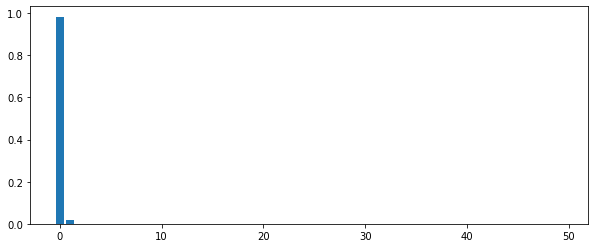

In [261]:
pcax.explained_variance_ratio_
f, ax = plt.subplots(1, figsize=(10, 4))
ax.bar(np.arange(pcax.explained_variance_ratio_.shape[0]), pcax.explained_variance_ratio_)

In [264]:
datasetx_pcax[:,:2].shape

(725, 2)

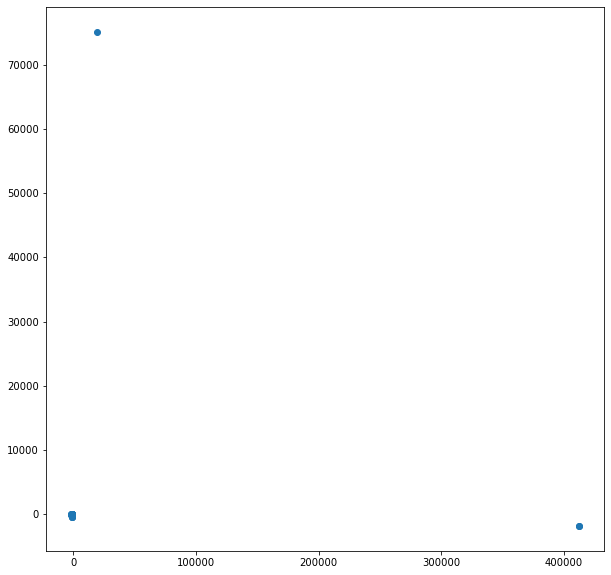

In [265]:
f, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(datasetx_pcax[:,0], datasetx_pcax[:,1])

In [266]:
kmx = KMeans(3)
kmx.fit(datasetx_pcax[:,:2])

KMeans(n_clusters=3)

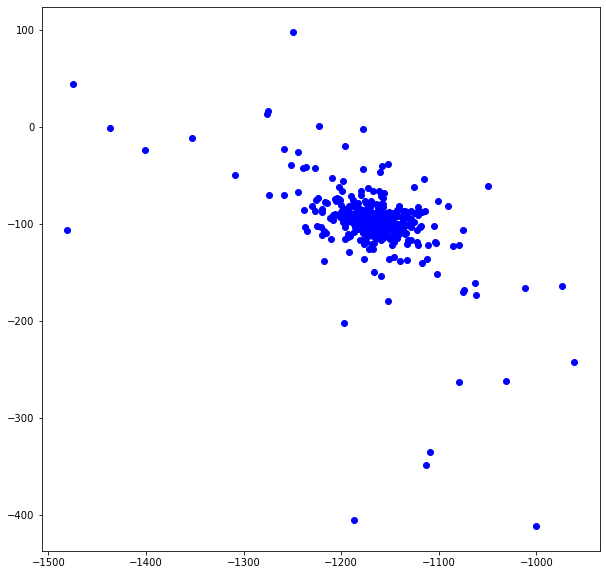

In [271]:
clab = plt.cm.brg(np.linspace(0, 1, num=3))
f, ax = plt.subplots(1, figsize=(10,10))
cluster = datasetx_pcax[kmx.labels_ == 0]
ax.scatter(cluster[:,0], cluster[:,1], color=clab[0])

In [273]:
np.mean(kmx.labels_ == 0)

0.9958620689655172

In [274]:
scalerx = RobustScaler()
scaledx_datasetx = scaler.fit_transform(dataset[kmx.labels_ == 0])
pcax = PCA(n_components=50)
pcax.fit(scaledx_datasetx)
datasetx_pcax = pcax.transform(scaledx_datasetx)

<BarContainer object of 50 artists>

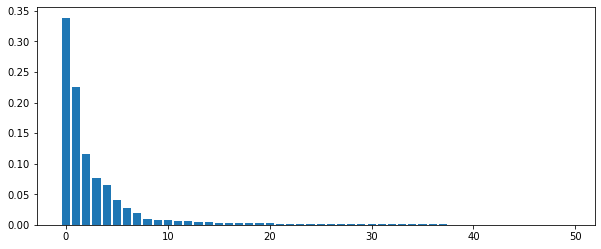

In [276]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.bar(np.arange(pcax.explained_variance_ratio_.shape[0]), pcax.explained_variance_ratio_)

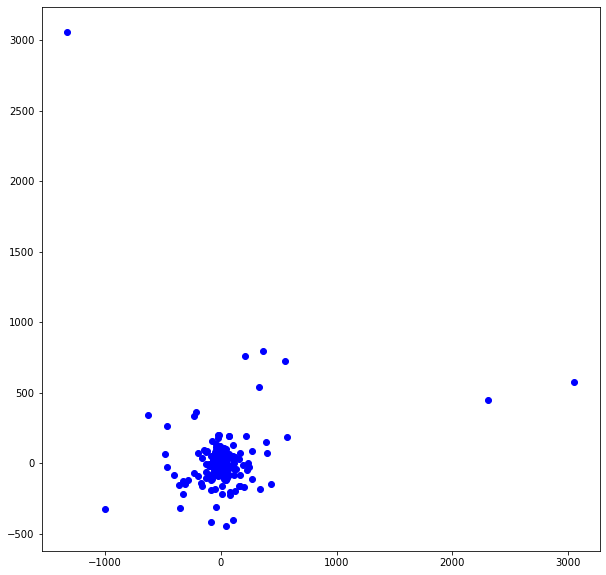

In [277]:
clab = plt.cm.brg(np.linspace(0, 1, num=3))
f, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(datasetx_pcax[:,0], datasetx_pcax[:,1], color=clab[0])

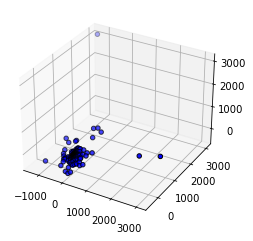

In [279]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(datasetx_pcax[:,0], datasetx_pcax[:,1], datasetx_pcax[:,1], color=clab[0], edgecolor="black")

In [288]:
vertex_map = copy(kmx.labels_ == 0)

SCORES_DICT = {}
for i in range(3):
    scores = np.zeros(vertex_map.shape[0])
    scores[vertex_map] = datasetx_pcax[:,0]
    SCORES_DICT[i] = scores

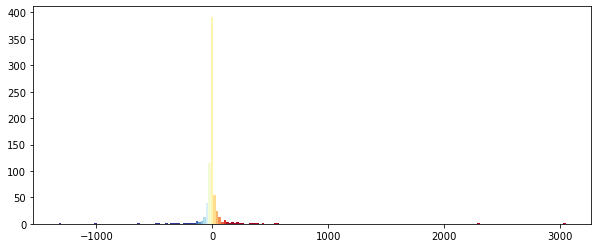

In [445]:
nbins = 200
divnorm = colors.TwoSlopeNorm(vmin=-150, vcenter=0, vmax=150)
# divnorm.autoscale(SCORES_DICT[0])
c = cm.ScalarMappable(divnorm, cmap="RdYlBu_r")

f, ax = plt.subplots(1, figsize=(10, 4))
hist, bins, barlist = ax.hist(SCORES_DICT[0], bins=nbins)

for ix, x in enumerate(barlist):
    plt.setp(x, "facecolor", c.to_rgba(bins[ix+1]))

In [435]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm, colors


def data_to_rgb(data, n_bins, cmap, vmin, vmax, vcenter=0, ret_map=False):
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    c = cm.ScalarMappable(divnorm, cmap=cmap)
    bins = np.histogram_bin_edges(data, bins=n_bins)
    bin_ranges = list(zip(bins[:-1], bins[1:]))
    colour_mapped = np.zeros((data.shape[0], 4))
    for br_ix, br in enumerate(bin_ranges):
        map_c = (data >= br[0]) & (data < br[1])
        colour_mapped[map_c,:] = c.to_rgba(bins[1:][br_ix])
    if not ret_map:
        return colour_mapped
    elif ret_map:
        return colour_mapped, c

    
# f, ax = plt.subplots()

In [440]:
pca_map_col, c = data_to_rgb(SCORES_DICT[0], 200, "RdYlBu_r", -150, 150, ret_map=True)

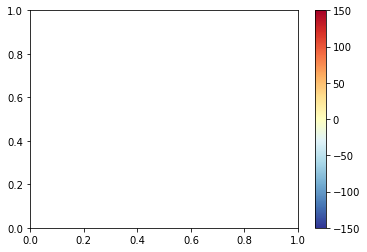

In [441]:
f, ax = plt.subplots(1)
f.colorbar(c, ax=ax)

In [421]:
np.unique(atlas_labels)

array([b'???', b'L_10d_ROI', b'L_10pp_ROI', b'L_10r_ROI', b'L_10v_ROI',
       b'L_11l_ROI', b'L_13l_ROI', b'L_1_ROI', b'L_23c_ROI', b'L_23d_ROI',
       b'L_24dd_ROI', b'L_24dv_ROI', b'L_25_ROI', b'L_2_ROI',
       b'L_31a_ROI', b'L_31pd_ROI', b'L_31pv_ROI', b'L_33pr_ROI',
       b'L_3a_ROI', b'L_3b_ROI', b'L_43_ROI', b'L_44_ROI', b'L_45_ROI',
       b'L_46_ROI', b'L_47l_ROI', b'L_47m_ROI', b'L_47s_ROI', b'L_4_ROI',
       b'L_52_ROI', b'L_55b_ROI', b'L_5L_ROI', b'L_5m_ROI', b'L_5mv_ROI',
       b'L_6a_ROI', b'L_6d_ROI', b'L_6ma_ROI', b'L_6mp_ROI', b'L_6r_ROI',
       b'L_6v_ROI', b'L_7AL_ROI', b'L_7Am_ROI', b'L_7PC_ROI',
       b'L_7PL_ROI', b'L_7Pm_ROI', b'L_7m_ROI', b'L_8Ad_ROI',
       b'L_8Av_ROI', b'L_8BL_ROI', b'L_8BM_ROI', b'L_8C_ROI',
       b'L_9-46d_ROI', b'L_9a_ROI', b'L_9m_ROI', b'L_9p_ROI', b'L_A1_ROI',
       b'L_A4_ROI', b'L_A5_ROI', b'L_AAIC_ROI', b'L_AIP_ROI',
       b'L_AVI_ROI', b'L_DVT_ROI', b'L_EC_ROI', b'L_FEF_ROI',
       b'L_FFC_ROI', b'L_FOP1_ROI', b'L_FOP2_R

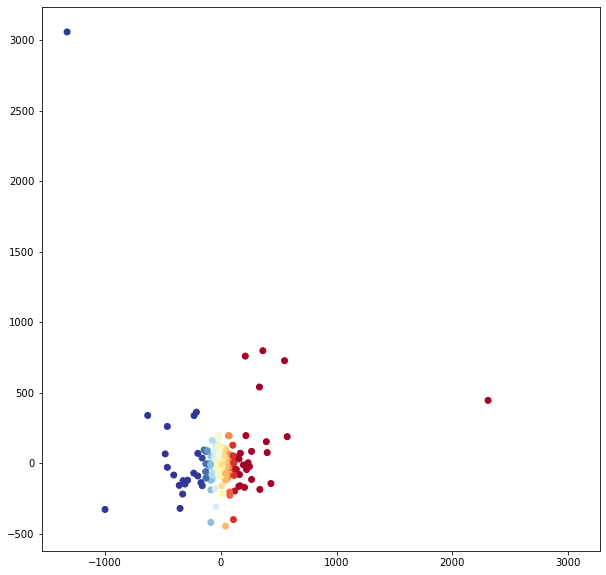

In [446]:
clab = plt.cm.brg(np.linspace(0, 1, num=3))
f, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(datasetx_pcax[:,0], datasetx_pcax[:,1], c=pca_map_col[vertex_map])

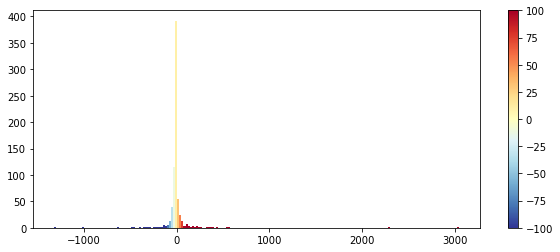

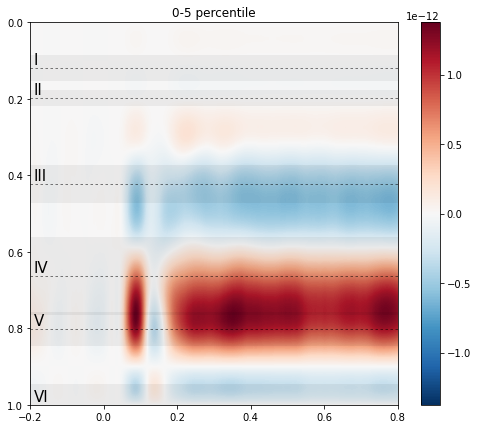

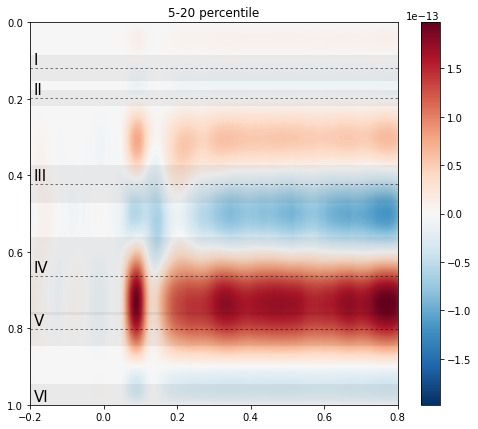

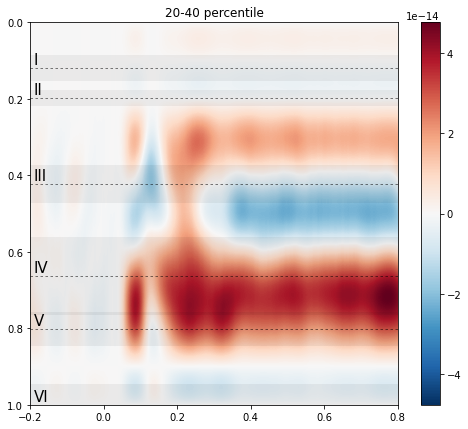

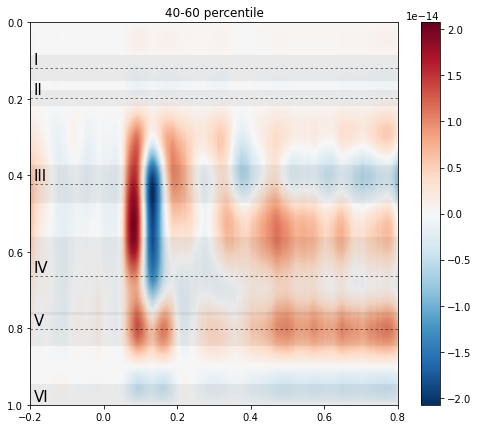

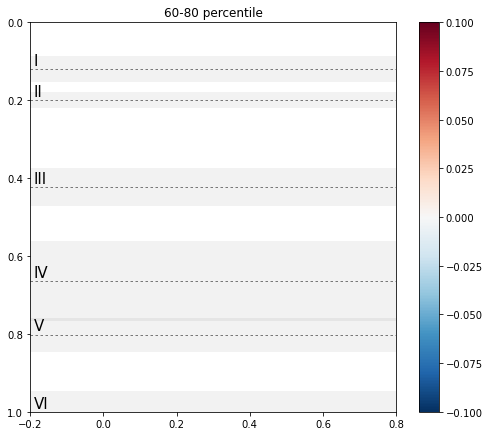

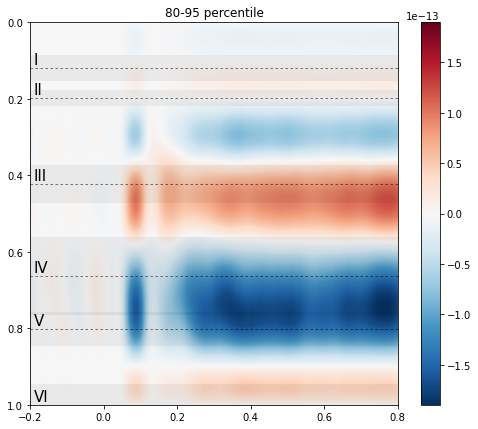

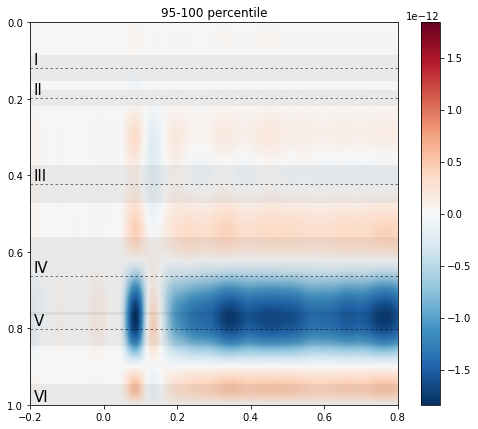

In [474]:
pr = [0, 5, 20, 40, 60, 80, 95, 100]
dt = SCORES_DICT[1]
pca_map_col, c = data_to_rgb(dt, 200, "RdYlBu_r", -100, 100, ret_map=True)

f, ax = plt.subplots(1, figsize=(10, 4))
hist, bins, barlist = ax.hist(dt, bins=nbins)
f.colorbar(c, ax=ax)
for ix, x in enumerate(barlist):
    plt.setp(x, "facecolor", c.to_rgba(bins[ix+1]))


for pr_r in list(zip(pr[:-1], pr[1:])):
    a = np.percentile(dt, pr_r[0])
    b = np.percentile(dt, pr_r[1])
    trmap_ = (dt >= a) & (dt < b)
    csd_to_go = np.mean(smooth[trmap_], axis=0)
    f, ax = plt.subplots(1,1, figsize=(7,6), facecolor="white")
    baseline = np.mean(csd_to_go[:, np.where(times["visual"] < -0.01)], axis=2)
    plot_csd(
        csd_to_go - baseline, ROI_vertices["L_V1_ROI"],
        info["big_brain_layers_path"], times["visual"], ax
    )
    ax.set_title(
        "{}-{} percentile".format(*pr_r)
    )

In [479]:
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = pca_map_col[ix][:3]
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
mask = [i.decode("utf=8")[0] == "R" for i in atlas_labels]
mesh.remove_vertices_by_mask(mask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)